# Google drive mount

In [ ]:
# 계정 드라이브와 마운트하기
# 모두 선택해서 동의해야 마운트가 오류없이 됩니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파일 가져오기

In [ ]:
!unzip /content/drive/MyDrive/Kaggle01/rokey-boot-camp-mini-competition.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/train_data/00000.png  
  inflating: data/train_data/00001.png  
  inflating: data/train_data/00002.png  
  inflating: data/train_data/00003.png  
  inflating: data/train_data/00004.png  
  inflating: data/train_data/00005.png  
  inflating: data/train_data/00006.png  
  inflating: data/train_data/00007.png  
  inflating: data/train_data/00008.png  
  inflating: data/train_data/00009.png  
  inflating: data/train_data/00010.png  
  inflating: data/train_data/00011.png  
  inflating: data/train_data/00012.png  
  inflating: data/train_data/00013.png  
  inflating: data/train_data/00014.png  
  inflating: data/train_data/00015.png  
  inflating: data/train_data/00016.png  
  inflating: data/train_data/00017.png  
  inflating: data/train_data/00018.png  
  inflating: data/train_data/00019.png  
  inflating: data/train_data/00020.png  
  inflating: data/train_data/00021.png  
  inflating: data/tr

In [ ]:
# 랜덤성 제어를 위한 seed 고정
import random
import numpy as np
import torch
import torchvision.ops as ops

seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [ ]:
!pip install grad-cam tensorboard -q

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR,MultiStepLR
from torchvision.models import resnet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

import torchvision.models as models
from sklearn.model_selection import train_test_split
from google.colab import files
from glob import glob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#======================== Utils ==========================================
def tta_predict(model, images):

    # original
    logits1 = model(images)
    # horizontal flip
    images_flip = torch.flip(images, dims=[3])  # N,C,H,W
    logits2 = model(images_flip)
    # softmax avergage
    probs = (F.softmax(logits1, dim=1) +
             F.softmax(logits2, dim=1)) / 2

    return probs

def tta_predict_4(model, images):
    logits = []

    # original
    logits.append(model(images))

    # horizontal flip
    logits.append(model(torch.flip(images, dims=[3])))

    # vertical flip
    logits.append(model(torch.flip(images, dims=[2])))

    # shift TTA
    pad = 4
    x = F.pad(images, (pad, pad, pad, pad), mode='reflect')
    logits.append(model(x[:, :, :96, :96]))
    logits.append(model(x[:, :, -96:, -96:]))

    logits = torch.stack(logits, dim=0).mean(dim=0)
    return F.softmax(logits, dim=1)


class SoftTargetCrossEntropy(nn.Module):
    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=1)
        return -(targets * log_probs).sum(dim=1).mean()

###visualization
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(history['train_losses'], label='Train Loss', linewidth=2.5, color='#3498db')
    axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2.5, color='#e74c3c')
    axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=12, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle='--')

    axes[1].plot(history['train_accs'], label='Train Accuracy', linewidth=2.5, color='#3498db')
    axes[1].plot(history['val_accs_ema'], label='Validation Accuracy', linewidth=2.5, color='#e74c3c')
    axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=12, loc='lower right')
    axes[1].grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

def download_model(model):
  torch.save(model.state_dict(), 'best_model.pth')
  files.download('best_model.pth')

def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Predicting'):
            inputs = inputs.to(device)

            with autocast():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0],
        cbar_kws={'label': 'Count'}
    )
    axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1],
        cbar_kws={'label': 'Proportion'},
        vmin=0,
        vmax=1
    )
    axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f'{"Class":15s} {"Precision":>10s} {"Recall":>10s} {"F1-Score":>10s} {"Support":>10s}')
    print('-' * 70)

    for i, name in enumerate(class_names):
        precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
        recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = cm[i, :].sum()

        print(f'{name:15s} {precision:10.4f} {recall:10.4f} {f1:10.4f} {support:10d}')

    print('=' * 70)


class ModelEMA:
    """ Model Exponential Moving Average V2 from timm"""
    def __init__(self, model, decay=0.999, device=None):
        self.module = copy.deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


In [ ]:

############################Dataset##################################
#--- for custmoizing dataset
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        train_df = pd.read_csv(f"{data_path}/train_data.csv")

        self.name2label = dict(zip(train_df["name"], train_df["label"]))

        if self.train:
            self.img_path = glob(f"{data_path}/train_data/*.png")
            self.labels =  [self.name2label[d.split("/")[-1]] for d in self.img_path]
        else:
            self.img_path = glob(f"{data_path}/test_data/*.png")
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.labels[index]
        else:
            return img, self.img_path[index].split("/")[-1]

#-- to apply transform after customizing dataset
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
#---- for switiching on/off the mixup/cutmix
class MixupCollate:
    def __init__(self, mixup_fn, switch_epoch):
        self.mixup_fn = mixup_fn
        self.switch_epoch = switch_epoch
        self.epoch = 0

    def set_epoch(self, epoch):
        self.epoch = epoch

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.tensor(labels)

        if self.epoch < self.switch_epoch :
            return self.mixup_fn(images, labels)
        else:
            return images, labels

#-- make train_test set
def pre_process_data(transform,batch_size,is_train,train_val_split=0,collate_fn=None):
  data_path = "./data"
  #data augumentation
  # custmoizing data
  if is_train:
    train_dataset = MyDataset(data_path, train=is_train, transform=None)
    # split the traingdata to train and validation datasets
    if train_val_split is None:
        train_base = torch.utils.data.Subset(train_dataset, train_idx)
        val_base = 0

    else:
      train_idx, val_idx = train_test_split(
          np.arange(len(train_dataset)),
          test_size=train_val_split,
          stratify=train_dataset.labels,
          random_state=0
      )
      train_base = torch.utils.data.Subset(train_dataset, train_idx)
      val_base = torch.utils.data.Subset(train_dataset, val_idx)
    # apply transform
    train_data = ApplyTransform(train_base, transform=transform)
    val_data = ApplyTransform(val_base, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader
  else :
    test_dataset = MyDataset(data_path, train=is_train, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader




In [ ]:
############################Model##################################

##### SEBLock
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True,drop_prob = 0.1):
        super().__init__()
        self.use_se = use_se
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.SiLU(inplace=True)
        self.act2 = nn.SiLU(inplace=True)

        # selectable SEblock
        if self.use_se: self.se = SEBlock(out_channels)
        self.drop_path = ops.StochasticDepth(drop_prob, "row")

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.act1(self.bn1(self.conv1(x))) # ReLU -> SiLU
        out = self.bn2(self.conv2(out))

        if self.use_se:
            out = self.se(out)

        out = self.drop_path(out) + identity
        return self.act2(out) # ReLU -> SiLU

class SmallResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 3, stride=1, use_se=False)
        self.layer2 = self._make_layer(128, 3, stride=2, use_se=True)
        self.layer3 = self._make_layer(256, 3, stride=2, use_se=True)
        self.layer4 = self._make_layer(512, 4, stride=2, use_se=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(0.1)
        self.fc = nn.Linear(512,num_classes)

        self._init_weights()

    def _make_layer(self, out_channels, num_blocks, stride, use_se):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, use_se=use_se))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1, use_se=use_se))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        # Stem
        x = F.silu(self.bn1(self.conv1(x)))
        # Stages
        x = self.layer1(x) # 64x96x96 (use_se=False)
        x = self.layer2(x) # 128x48x48 (use_se=True)
        x = self.layer3(x) # 256x24x24 (use_se=True)
        x = self.layer4(x) # 512x12x12 (use_se=True)
        # Global Average Pooling & Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(self.drop(x))
        return x






In [ ]:
#############Config#################
######dataset
mixup_collate_swiching_epoch = 120
val_train_split = 0.1
batch_size = 64
#train
num_epochs = 150
switching_epoch = 50
patience = 40 # early stopping
##### optimizer
lr = 0.1 # learning rate
weight_decay = 5e-4
#warm-up scheudler
warmup_epochs =8
start_factor=0.1
end_factor=1.0
min_lr = 1e-6





In [ ]:

###data process
train_transform =  transforms.Compose([

    v2.RandAugment(num_ops=2, magnitude=5),
    v2.RandomHorizontalFlip(0.5),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

test_transform =  transforms.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ])
collate = v2.RandomChoice([
    v2.CutMix(num_classes=10,alpha=0.5),
    v2.MixUp(num_classes=10, alpha=0.3)
    ])

mixup_collate = MixupCollate(
    mixup_fn=collate,
    switch_epoch=mixup_collate_swiching_epoch
)

train_loader,val_loader = pre_process_data(transform = train_transform,batch_size=batch_size,is_train=True,train_val_split= val_train_split,collate_fn=mixup_collate)
test_loader = pre_process_data(transform = test_transform,batch_size=batch_size,is_train=False)

##################training


# model = models.resnet18(pretrained=None)


# model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.maxpool = nn.Identity()
# model.fc = nn.Linear(512, 10) # 클래스 개수 10개로 변경
model = SmallResNet()
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.05
)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs
)

main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs - warmup_epochs, eta_min=min_lr
)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[warmup_epochs]
)

ema = ModelEMA(model, decay=0.999, device=device)

# for record
history = {}
train_losses, train_accs = [], []
val_losses = []
val_accs_model = []
val_accs_ema = []

best_val_acc = 0.0
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    mixup_collate.set_epoch(epoch)
    model.train()

    total_loss = 0
    train_len = 0
    train_correct = 0

    if epoch < mixup_collate_swiching_epoch:
        criterion = SoftTargetCrossEntropy()
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.03)

    val_criterion = nn.CrossEntropyLoss()

    # --- Training Phase ---
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ema.update(model)

        pred = outputs.argmax(dim=1)
        target_indices = labels.argmax(dim=1) if labels.dim() > 1 else labels
        train_correct += (pred == target_indices).sum().item()

        total_loss += loss.item() * images.size(0)
        train_len += images.size(0)

        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / train_len:.4f}')

    train_losses.append(total_loss / train_len)
    train_accs.append(train_correct / train_len)

    # --- Validation Phase ---
    model.eval()
    ema.module.eval()

    v_loss_sum = 0.0
    v_correct_model = 0
    v_correct_ema = 0
    v_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            target = labels.argmax(dim=1) if labels.dim() > 1 else labels
            v_total += images.size(0)


            out_model = model(images)
            v_loss_sum += val_criterion(out_model, labels).item() * images.size(0)
            v_correct_model += (out_model.argmax(dim=1) == target).sum().item()

            out_ema = ema.module(images)
            v_correct_ema += (out_ema.argmax(dim=1) == target).sum().item()


    avg_v_loss = v_loss_sum / v_total
    acc_model = v_correct_model / v_total
    acc_ema = v_correct_ema / v_total

    val_losses.append(avg_v_loss)
    val_accs_model.append(acc_model)
    val_accs_ema.append(acc_ema)

    scheduler.step()

    if acc_ema > best_val_acc:
        best_val_acc = acc_ema
        best_model_state = copy.deepcopy(ema.module.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f'Val Loss: {avg_v_loss:.4f} | Model Acc: {acc_model*100:.2f}% | EMA Acc: {acc_ema*100:.2f}%')

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break


if best_model_state is not None:
    model.load_state_dict(best_model_state)

history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs_model': val_accs_model,
    'val_accs_ema': val_accs_ema
}


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Epoch [1/150], Loss: 2.2972: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 2.2268 | Model Acc: 18.00% | EMA Acc: 10.00%


Epoch [2/150], Loss: 2.1477: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.8049 | Model Acc: 31.20% | EMA Acc: 10.00%


Epoch [3/150], Loss: 2.0442: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 1.6892 | Model Acc: 33.20% | EMA Acc: 10.00%


Epoch [4/150], Loss: 1.9324: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 1.5942 | Model Acc: 38.40% | EMA Acc: 10.00%


Epoch [5/150], Loss: 1.8784: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.5906 | Model Acc: 38.00% | EMA Acc: 10.00%


Epoch [6/150], Loss: 1.8866: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 1.4985 | Model Acc: 43.80% | EMA Acc: 10.00%


Epoch [7/150], Loss: 1.7981: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.4355 | Model Acc: 46.40% | EMA Acc: 10.00%


Epoch [8/150], Loss: 1.7279: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.4038 | Model Acc: 47.80% | EMA Acc: 11.40%


Epoch [9/150], Loss: 1.7185: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 1.2514 | Model Acc: 52.40% | EMA Acc: 13.60%


Epoch [10/150], Loss: 1.6756: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 1.1770 | Model Acc: 58.40% | EMA Acc: 12.20%


Epoch [11/150], Loss: 1.6519: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.2131 | Model Acc: 54.00% | EMA Acc: 10.00%


Epoch [12/150], Loss: 1.6839: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 1.1714 | Model Acc: 54.40% | EMA Acc: 10.20%


Epoch [13/150], Loss: 1.5875: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 1.0444 | Model Acc: 61.60% | EMA Acc: 11.80%


Epoch [14/150], Loss: 1.5735: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 1.1203 | Model Acc: 60.40% | EMA Acc: 14.80%


Epoch [15/150], Loss: 1.5349: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 1.0301 | Model Acc: 64.20% | EMA Acc: 16.60%


Epoch [16/150], Loss: 1.4980: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.9718 | Model Acc: 65.20% | EMA Acc: 20.00%


Epoch [17/150], Loss: 1.5456: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.9384 | Model Acc: 69.00% | EMA Acc: 22.80%


Epoch [18/150], Loss: 1.4896: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.9815 | Model Acc: 66.40% | EMA Acc: 26.80%


Epoch [19/150], Loss: 1.5235: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.8711 | Model Acc: 70.60% | EMA Acc: 33.20%


Epoch [20/150], Loss: 1.4367: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.9475 | Model Acc: 67.80% | EMA Acc: 34.80%


Epoch [21/150], Loss: 1.4670: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.8864 | Model Acc: 68.00% | EMA Acc: 38.00%


Epoch [22/150], Loss: 1.3365: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.8791 | Model Acc: 68.80% | EMA Acc: 42.20%


Epoch [23/150], Loss: 1.3716: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.8697 | Model Acc: 70.00% | EMA Acc: 45.80%


Epoch [24/150], Loss: 1.2964: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.9110 | Model Acc: 64.80% | EMA Acc: 47.40%


Epoch [25/150], Loss: 1.2859: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.7632 | Model Acc: 72.60% | EMA Acc: 50.80%


Epoch [26/150], Loss: 1.2252: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.7661 | Model Acc: 72.40% | EMA Acc: 52.60%


Epoch [27/150], Loss: 1.2652: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


Val Loss: 0.7641 | Model Acc: 74.00% | EMA Acc: 56.80%


Epoch [28/150], Loss: 1.2253: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.7562 | Model Acc: 73.80% | EMA Acc: 59.40%


Epoch [29/150], Loss: 1.2297: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.7127 | Model Acc: 75.20% | EMA Acc: 60.80%


Epoch [30/150], Loss: 1.2404: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.6725 | Model Acc: 78.40% | EMA Acc: 62.20%


Epoch [31/150], Loss: 1.2549: 100%|██████████| 71/71 [00:13<00:00,  5.14it/s]


Val Loss: 0.6981 | Model Acc: 76.60% | EMA Acc: 65.00%


Epoch [32/150], Loss: 1.2623: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.6876 | Model Acc: 76.80% | EMA Acc: 66.80%


Epoch [33/150], Loss: 1.2022: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.7813 | Model Acc: 71.60% | EMA Acc: 68.60%


Epoch [34/150], Loss: 1.2357: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.7224 | Model Acc: 75.80% | EMA Acc: 70.60%


Epoch [35/150], Loss: 1.2493: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.6215 | Model Acc: 81.00% | EMA Acc: 71.80%


Epoch [36/150], Loss: 1.3208: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.7220 | Model Acc: 77.60% | EMA Acc: 72.40%


Epoch [37/150], Loss: 1.2007: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.6441 | Model Acc: 81.40% | EMA Acc: 73.00%


Epoch [38/150], Loss: 1.1664: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.6841 | Model Acc: 76.20% | EMA Acc: 74.00%


Epoch [39/150], Loss: 1.2390: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.7542 | Model Acc: 73.80% | EMA Acc: 74.80%


Epoch [40/150], Loss: 1.0569: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.5982 | Model Acc: 79.20% | EMA Acc: 75.40%


Epoch [41/150], Loss: 1.1147: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.6298 | Model Acc: 79.80% | EMA Acc: 77.40%


Epoch [42/150], Loss: 1.1605: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.6903 | Model Acc: 76.40% | EMA Acc: 77.60%


Epoch [43/150], Loss: 1.0932: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.6186 | Model Acc: 80.00% | EMA Acc: 78.20%


Epoch [44/150], Loss: 1.1976: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


Val Loss: 0.6627 | Model Acc: 77.00% | EMA Acc: 79.00%


Epoch [45/150], Loss: 1.0213: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.5607 | Model Acc: 80.40% | EMA Acc: 79.60%


Epoch [46/150], Loss: 1.0726: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.6263 | Model Acc: 78.20% | EMA Acc: 80.00%


Epoch [47/150], Loss: 1.0666: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.6022 | Model Acc: 80.20% | EMA Acc: 79.80%


Epoch [48/150], Loss: 0.9678: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.5789 | Model Acc: 81.40% | EMA Acc: 79.80%


Epoch [49/150], Loss: 1.0049: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.5374 | Model Acc: 82.20% | EMA Acc: 80.40%


Epoch [50/150], Loss: 1.0141: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.5692 | Model Acc: 83.20% | EMA Acc: 81.00%


Epoch [51/150], Loss: 1.0670: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.6155 | Model Acc: 80.20% | EMA Acc: 81.60%


Epoch [52/150], Loss: 0.8995: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.6339 | Model Acc: 77.80% | EMA Acc: 82.60%


Epoch [53/150], Loss: 1.0798: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4975 | Model Acc: 83.00% | EMA Acc: 82.60%


Epoch [54/150], Loss: 0.9788: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.5479 | Model Acc: 83.20% | EMA Acc: 82.60%


Epoch [55/150], Loss: 1.0307: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.4918 | Model Acc: 84.40% | EMA Acc: 83.00%


Epoch [56/150], Loss: 1.0231: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4827 | Model Acc: 85.60% | EMA Acc: 83.40%


Epoch [57/150], Loss: 0.9593: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.6277 | Model Acc: 81.20% | EMA Acc: 84.00%


Epoch [58/150], Loss: 1.0409: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


Val Loss: 0.4823 | Model Acc: 84.60% | EMA Acc: 84.40%


Epoch [59/150], Loss: 0.9593: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.5905 | Model Acc: 81.80% | EMA Acc: 84.40%


Epoch [60/150], Loss: 0.9405: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.5195 | Model Acc: 84.40% | EMA Acc: 85.00%


Epoch [61/150], Loss: 0.9379: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.5029 | Model Acc: 83.60% | EMA Acc: 85.60%


Epoch [62/150], Loss: 0.8575: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4713 | Model Acc: 85.40% | EMA Acc: 86.00%


Epoch [63/150], Loss: 1.0036: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4977 | Model Acc: 84.60% | EMA Acc: 86.00%


Epoch [64/150], Loss: 0.8889: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.5040 | Model Acc: 84.40% | EMA Acc: 86.20%


Epoch [65/150], Loss: 0.8763: 100%|██████████| 71/71 [00:13<00:00,  5.15it/s]


Val Loss: 0.5086 | Model Acc: 84.00% | EMA Acc: 86.20%


Epoch [66/150], Loss: 0.8481: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.5194 | Model Acc: 85.40% | EMA Acc: 86.40%


Epoch [67/150], Loss: 0.9169: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.4822 | Model Acc: 84.80% | EMA Acc: 87.00%


Epoch [68/150], Loss: 0.8617: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4182 | Model Acc: 87.40% | EMA Acc: 86.80%


Epoch [69/150], Loss: 0.8101: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4799 | Model Acc: 84.80% | EMA Acc: 87.00%


Epoch [70/150], Loss: 0.8886: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.5229 | Model Acc: 85.20% | EMA Acc: 87.00%


Epoch [71/150], Loss: 0.8099: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4561 | Model Acc: 87.40% | EMA Acc: 87.60%


Epoch [72/150], Loss: 0.9061: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.5149 | Model Acc: 84.80% | EMA Acc: 87.60%


Epoch [73/150], Loss: 0.7616: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4920 | Model Acc: 85.40% | EMA Acc: 87.80%


Epoch [74/150], Loss: 0.8884: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.5000 | Model Acc: 85.40% | EMA Acc: 88.20%


Epoch [75/150], Loss: 0.8282: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4556 | Model Acc: 87.40% | EMA Acc: 88.40%


Epoch [76/150], Loss: 0.8127: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4379 | Model Acc: 86.60% | EMA Acc: 88.60%


Epoch [77/150], Loss: 0.8592: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4243 | Model Acc: 87.00% | EMA Acc: 88.60%


Epoch [78/150], Loss: 0.8880: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.5394 | Model Acc: 83.20% | EMA Acc: 89.00%


Epoch [79/150], Loss: 0.8625: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4306 | Model Acc: 88.20% | EMA Acc: 89.00%


Epoch [80/150], Loss: 0.8577: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4494 | Model Acc: 86.60% | EMA Acc: 88.80%


Epoch [81/150], Loss: 0.8705: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4765 | Model Acc: 86.60% | EMA Acc: 88.60%


Epoch [82/150], Loss: 0.8549: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4205 | Model Acc: 88.20% | EMA Acc: 88.40%


Epoch [83/150], Loss: 0.8276: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4240 | Model Acc: 88.60% | EMA Acc: 88.40%


Epoch [84/150], Loss: 0.7743: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4129 | Model Acc: 87.20% | EMA Acc: 88.40%


Epoch [85/150], Loss: 0.8326: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4705 | Model Acc: 86.60% | EMA Acc: 88.40%


Epoch [86/150], Loss: 0.8359: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4397 | Model Acc: 87.40% | EMA Acc: 89.00%


Epoch [87/150], Loss: 0.8036: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3973 | Model Acc: 88.60% | EMA Acc: 88.80%


Epoch [88/150], Loss: 0.8020: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4712 | Model Acc: 85.80% | EMA Acc: 89.00%


Epoch [89/150], Loss: 0.8392: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.3965 | Model Acc: 89.60% | EMA Acc: 89.00%


Epoch [90/150], Loss: 0.7920: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4171 | Model Acc: 88.20% | EMA Acc: 89.00%


Epoch [91/150], Loss: 0.7996: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.4056 | Model Acc: 88.60% | EMA Acc: 88.80%


Epoch [92/150], Loss: 0.8104: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3993 | Model Acc: 88.60% | EMA Acc: 89.00%


Epoch [93/150], Loss: 0.7562: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4050 | Model Acc: 89.80% | EMA Acc: 89.00%


Epoch [94/150], Loss: 0.8166: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.4587 | Model Acc: 86.80% | EMA Acc: 89.20%


Epoch [95/150], Loss: 0.7941: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4055 | Model Acc: 87.80% | EMA Acc: 89.40%


Epoch [96/150], Loss: 0.6990: 100%|██████████| 71/71 [00:13<00:00,  5.12it/s]


Val Loss: 0.4024 | Model Acc: 89.80% | EMA Acc: 89.40%


Epoch [97/150], Loss: 0.7969: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4008 | Model Acc: 88.60% | EMA Acc: 89.20%


Epoch [98/150], Loss: 0.7889: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.4109 | Model Acc: 89.60% | EMA Acc: 89.40%


Epoch [99/150], Loss: 0.7340: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.3910 | Model Acc: 88.00% | EMA Acc: 89.40%


Epoch [100/150], Loss: 0.7618: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.4154 | Model Acc: 89.40% | EMA Acc: 89.80%


Epoch [101/150], Loss: 0.8809: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.4281 | Model Acc: 87.40% | EMA Acc: 89.80%


Epoch [102/150], Loss: 0.7321: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3813 | Model Acc: 88.20% | EMA Acc: 89.80%


Epoch [103/150], Loss: 0.7367: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3735 | Model Acc: 89.00% | EMA Acc: 89.80%


Epoch [104/150], Loss: 0.6768: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.3966 | Model Acc: 88.60% | EMA Acc: 90.00%


Epoch [105/150], Loss: 0.7091: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.3690 | Model Acc: 88.20% | EMA Acc: 90.00%


Epoch [106/150], Loss: 0.7387: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3730 | Model Acc: 88.60% | EMA Acc: 89.80%


Epoch [107/150], Loss: 0.7241: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3584 | Model Acc: 90.00% | EMA Acc: 89.60%


Epoch [108/150], Loss: 0.7487: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.3614 | Model Acc: 89.60% | EMA Acc: 89.60%


Epoch [109/150], Loss: 0.7416: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3873 | Model Acc: 87.00% | EMA Acc: 89.40%


Epoch [110/150], Loss: 0.7391: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3606 | Model Acc: 89.00% | EMA Acc: 89.40%


Epoch [111/150], Loss: 0.6112: 100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Val Loss: 0.3739 | Model Acc: 88.60% | EMA Acc: 89.40%


Epoch [112/150], Loss: 0.7370: 100%|██████████| 71/71 [00:13<00:00,  5.17it/s]


Val Loss: 0.3610 | Model Acc: 88.60% | EMA Acc: 89.60%


Epoch [113/150], Loss: 0.6688: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3630 | Model Acc: 89.00% | EMA Acc: 89.60%


Epoch [114/150], Loss: 0.7040: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3874 | Model Acc: 89.00% | EMA Acc: 89.40%


Epoch [115/150], Loss: 0.6899: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3617 | Model Acc: 90.00% | EMA Acc: 89.40%


Epoch [116/150], Loss: 0.7648: 100%|██████████| 71/71 [00:13<00:00,  5.20it/s]


Val Loss: 0.3710 | Model Acc: 89.60% | EMA Acc: 89.40%


Epoch [117/150], Loss: 0.7377: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3727 | Model Acc: 89.00% | EMA Acc: 89.60%


Epoch [118/150], Loss: 0.7148: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3904 | Model Acc: 89.60% | EMA Acc: 89.80%


Epoch [119/150], Loss: 0.6392: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3674 | Model Acc: 89.60% | EMA Acc: 90.00%


Epoch [120/150], Loss: 0.6644: 100%|██████████| 71/71 [00:13<00:00,  5.19it/s]


Val Loss: 0.3527 | Model Acc: 90.40% | EMA Acc: 89.80%


Epoch [121/150], Loss: 0.2297: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.3027 | Model Acc: 91.00% | EMA Acc: 89.80%


Epoch [122/150], Loss: 0.2287: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.3066 | Model Acc: 91.20% | EMA Acc: 90.20%


Epoch [123/150], Loss: 0.2272: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.3242 | Model Acc: 90.00% | EMA Acc: 90.40%


Epoch [124/150], Loss: 0.2240: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.3154 | Model Acc: 91.00% | EMA Acc: 90.20%


Epoch [125/150], Loss: 0.2233: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.3035 | Model Acc: 91.20% | EMA Acc: 90.40%


Epoch [126/150], Loss: 0.2256: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.3118 | Model Acc: 90.60% | EMA Acc: 90.60%


Epoch [127/150], Loss: 0.2234: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.3079 | Model Acc: 90.60% | EMA Acc: 90.80%


Epoch [128/150], Loss: 0.2258: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.3099 | Model Acc: 91.60% | EMA Acc: 91.00%


Epoch [129/150], Loss: 0.2201: 100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Val Loss: 0.2981 | Model Acc: 91.20% | EMA Acc: 91.20%


Epoch [130/150], Loss: 0.2212: 100%|██████████| 71/71 [00:13<00:00,  5.27it/s]


Val Loss: 0.2943 | Model Acc: 91.60% | EMA Acc: 91.20%


Epoch [131/150], Loss: 0.2155: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2968 | Model Acc: 92.20% | EMA Acc: 91.20%


Epoch [132/150], Loss: 0.2200: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2878 | Model Acc: 92.00% | EMA Acc: 91.20%


Epoch [133/150], Loss: 0.2165: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.2990 | Model Acc: 92.00% | EMA Acc: 91.20%


Epoch [134/150], Loss: 0.2190: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.3066 | Model Acc: 91.00% | EMA Acc: 91.40%


Epoch [135/150], Loss: 0.2191: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.2865 | Model Acc: 91.20% | EMA Acc: 91.20%


Epoch [136/150], Loss: 0.2175: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2817 | Model Acc: 91.80% | EMA Acc: 91.20%


Epoch [137/150], Loss: 0.2233: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2932 | Model Acc: 91.20% | EMA Acc: 91.40%


Epoch [138/150], Loss: 0.2195: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2844 | Model Acc: 91.60% | EMA Acc: 91.40%


Epoch [139/150], Loss: 0.2174: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2914 | Model Acc: 92.60% | EMA Acc: 91.40%


Epoch [140/150], Loss: 0.2144: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2865 | Model Acc: 91.80% | EMA Acc: 91.40%


Epoch [141/150], Loss: 0.2178: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2901 | Model Acc: 92.00% | EMA Acc: 91.40%


Epoch [142/150], Loss: 0.2181: 100%|██████████| 71/71 [00:13<00:00,  5.27it/s]


Val Loss: 0.2897 | Model Acc: 92.00% | EMA Acc: 91.40%


Epoch [143/150], Loss: 0.2220: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2953 | Model Acc: 91.80% | EMA Acc: 91.40%


Epoch [144/150], Loss: 0.2162: 100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Val Loss: 0.2949 | Model Acc: 92.00% | EMA Acc: 91.40%


Epoch [145/150], Loss: 0.2148: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2926 | Model Acc: 91.20% | EMA Acc: 91.60%


Epoch [146/150], Loss: 0.2177: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2883 | Model Acc: 92.00% | EMA Acc: 91.60%


Epoch [147/150], Loss: 0.2141: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2885 | Model Acc: 91.80% | EMA Acc: 91.60%


Epoch [148/150], Loss: 0.2156: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2916 | Model Acc: 92.00% | EMA Acc: 91.80%


Epoch [149/150], Loss: 0.2159: 100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Val Loss: 0.2960 | Model Acc: 92.00% | EMA Acc: 91.80%


Epoch [150/150], Loss: 0.2177: 100%|██████████| 71/71 [00:13<00:00,  5.26it/s]


Val Loss: 0.2971 | Model Acc: 91.40% | EMA Acc: 91.80%


In [ ]:

train_transform =  transforms.Compose([

    v2.RandAugment(num_ops=2, magnitude=3),
    v2.RandomHorizontalFlip(0.5),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

data_path = '/content/drive/MyDrive/Kaggle01/Miniproject_Kaggel01/Miniproject_Kaggel1/best_model.pth'
model = SmallResNet()
model.load_state_dict(torch.load(data_path, map_location=device))
model.to(device)
f_epoch = 20
data_path = "./data"
train_dataset = MyDataset(data_path, train=True, transform=train_transform)
f_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0005,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=f_epoch,eta_min=min_lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()

    total_loss = 0
    train_len = 0
    train_correct = 0


    criterion = nn.CrossEntropyLoss()
    val_criterion = nn.CrossEntropyLoss()

    # --- Training Phase ---
    pbar = tqdm(enumerate(f_train_loader), total=len(f_train_loader))
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 79/79 [00:09<00:00,  8.54it/s]


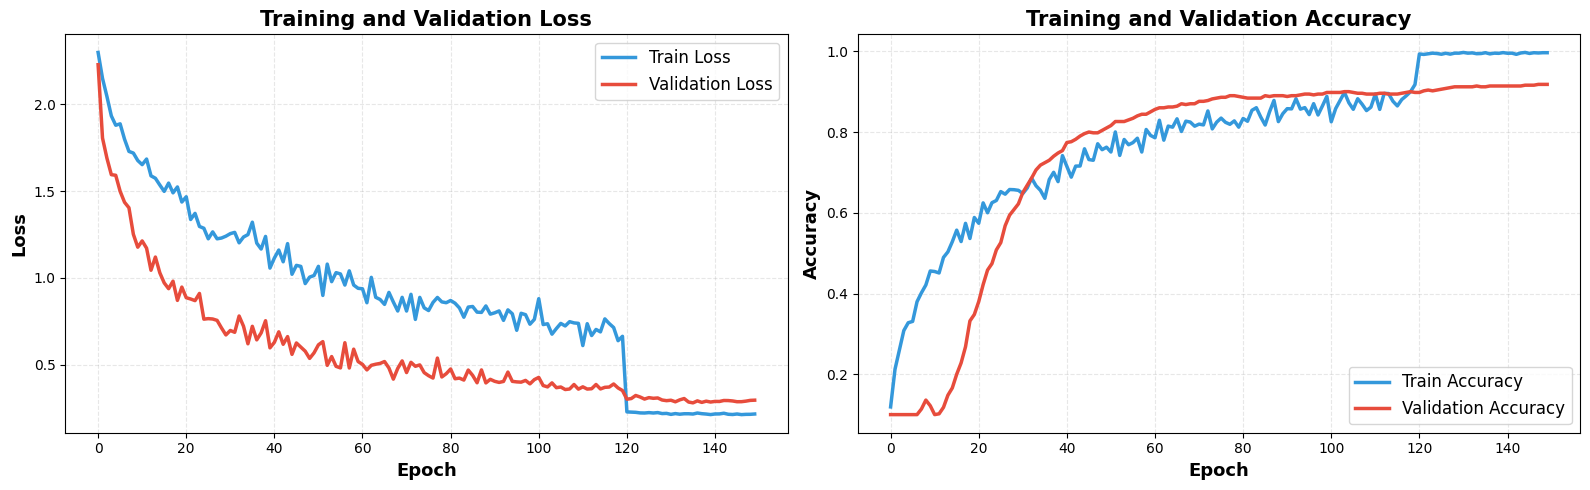

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predicting:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-3065975721.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


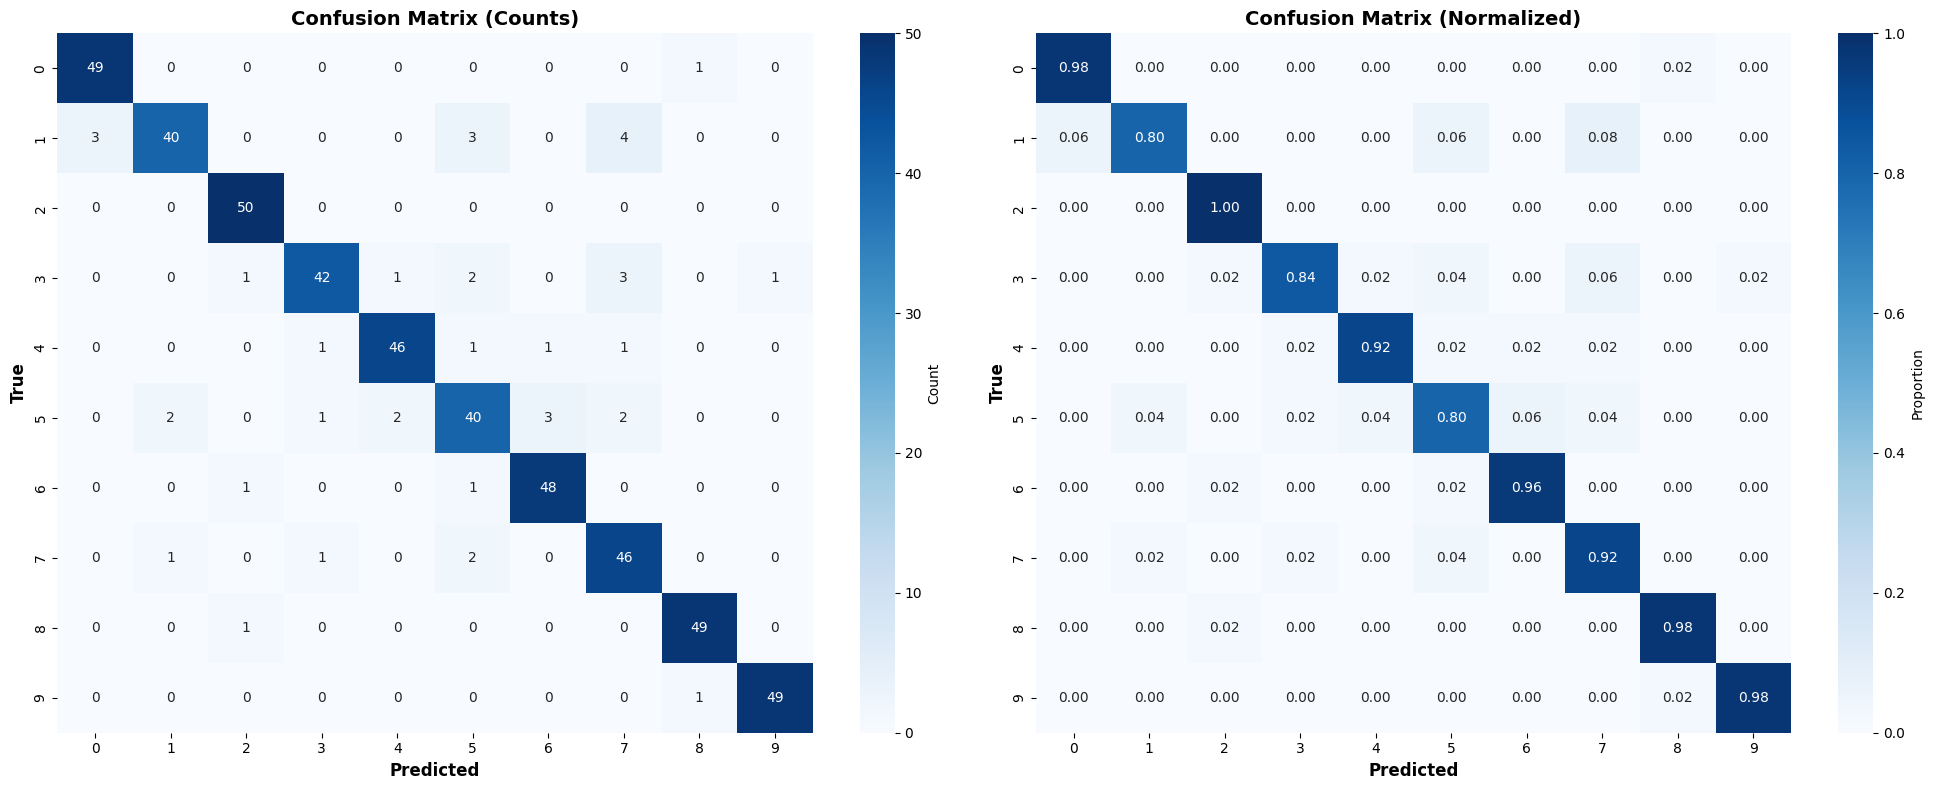


클래스별 성능:
Class            Precision     Recall   F1-Score    Support
----------------------------------------------------------------------


ValueError: Unknown format code 's' for object of type 'int'

In [ ]:
plot_history(history)
download_model(model)
class_name = np.arange(10)
y_pred, y_true, y_probs = get_all_predictions(model, val_loader, device)

plot_confusion_matrix(y_true, y_pred,class_name)

# Evaluation (Test)

In [ ]:
correct = 0
correct_tta = 0
total = 0

eval_model = ema.module
eval_model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        probs_tta = tta_predict(model, images)
        predicted_tta = probs_tta.argmax(dim=1)

        total += labels.size(0)

        correct += (predicted == labels).sum().item()
        correct_tta += (predicted_tta == labels).sum().item()

print(f'Final Accuracy (EMA) : {100 * correct / total:.2f} %')
print(f'Final Accuracy (EMA + TTA) : {100 * correct_tta / total:.2f} %')

Final Accuracy (EMA) : 91.80 %
Final Accuracy (EMA + TTA) : 91.60 %


In [ ]:

outputs = {
    'Id': [],
    'Prediction': []
}
test_transform =  transforms.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ])
test_loader = pre_process_data(transform = test_transform,batch_size=batch_size,is_train=False)

with torch.no_grad():
    for images, ids in tqdm(test_loader):
        images = images.to(device)

        probs_tta = tta_predict(model, images)
        predicted_tta = probs_tta.argmax(dim=1)

        outputs['Prediction'].extend(predicted_tta.cpu().tolist())
        outputs['Id'].extend(ids)

df = pd.DataFrame(outputs)
df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

print("submission.csv saved!")
file_path = "submission.csv"
files.download(file_path)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 125/125 [00:15<00:00,  8.30it/s]

submission.csv saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>